In [1]:
import re
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore') 

## 0.Load Data

In [2]:
data = {}
file1 = {
    'application_test': 'application_test.csv',
    'application_train': 'application_train.csv'
    }

file2 = {
    'bureau_balance': 'bureau_balance.csv',
    'bureau': 'bureau.csv',
    'credit_card_balance': 'credit_card_balance.csv',
    'installments_payments': 'installments_payments.csv',
    'POS_CASH_balance': 'POS_CASH_balance.csv',
    'previous_application': 'previous_application.csv'
    }

for key, name in file1.items():
    data[key] = pd.read_csv(f'dataset\\{name}', index_col=0)
    print(f'Dataset: {key} - Shape: {data[key].shape}')

for key, name in file2.items():
    data[key] = pd.read_csv(f'dataset\\{name}')
    print(f'Dataset: {key} - Shape: {data[key].shape}')


Dataset: application_test - Shape: (61502, 121)
Dataset: application_train - Shape: (246009, 122)
Dataset: bureau_balance - Shape: (27299925, 3)
Dataset: bureau - Shape: (1465325, 17)
Dataset: credit_card_balance - Shape: (3227965, 23)
Dataset: installments_payments - Shape: (7744758, 8)
Dataset: POS_CASH_balance - Shape: (8543375, 8)
Dataset: previous_application - Shape: (1413701, 37)


## 1.Data Preparation

Data cleaning + create new features + group values of each feature + encoding

In [3]:
def one_hot_encoding(df, col_list):
    encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoded = encoder.fit_transform(df[col_list])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(col_list))
    df = pd.concat([df, one_hot_df], axis=1)
    df = df.drop(col_list, axis=1)
    return df

In [4]:
def label_encoding(df, col_list):
    for col in col_list:
        label_encoder = preprocessing.LabelEncoder() 
        df[col] = label_encoder.fit_transform(df[col])
    return df

In [5]:
def reduce_features(data):
    corr_matrix = data.corr()
    print('Done calculating correlation matrix')

    target_corr = corr_matrix['TARGET']
    sorted_corr = target_corr.reindex(target_corr.sort_values(ascending=False).index)

    selected_features = sorted_corr[abs(sorted_corr) > 0.02].index.tolist()

    if 'SK_ID_CURR' not in selected_features:
        selected_features.append('SK_ID_CURR')

    low_corr_features_to_drop = set(data.columns) - set(selected_features)
    
    data = data[selected_features]
    print('Done dropping features with low correlation with the target variable')

    ##############################################################################################################
    # Recalculate the correlation matrix for the filtered data
    corr_matrix = data.corr()
    
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    corr_pairs = upper_tri.unstack().dropna()
    corr_pairs = pd.DataFrame(corr_pairs, columns=['Correlation'])
    corr_pairs.reset_index(inplace=True)
    corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
    corr_pairs['AbsCorrelation'] = corr_pairs['Correlation'].abs()
    high_corr_pairs = corr_pairs[corr_pairs['AbsCorrelation'] > 0.8]

    high_corr_features_to_drop = set()

    for index, row in high_corr_pairs.iterrows():
        feature1 = row['Feature1']
        feature2 = row['Feature2']
        
        corr_feature1 = abs(target_corr.get(feature1, 0))
        corr_feature2 = abs(target_corr.get(feature2, 0))
        
        if corr_feature1 > corr_feature2:
            high_corr_features_to_drop.add(feature2)
        else:
            high_corr_features_to_drop.add(feature1)

    features_to_drop = low_corr_features_to_drop.union(high_corr_features_to_drop)

    for col in high_corr_features_to_drop:
        if col in data.columns and col != 'SK_ID_CURR':
            data.drop(col, axis=1, inplace=True)

    return data, features_to_drop


### a.application_train + application_tesst

In [6]:
def cleaning_application(data_train, data_test):

    ##############################################################################################################
    #CHECK VALUES

    #Categorical variable
    data_train = data_train[(data_train['CODE_GENDER'] != 'XNA') & (data_train['OBS_60_CNT_SOCIAL_CIRCLE'] != 344)]

    data_train.loc[(~data_train['NAME_TYPE_SUITE'].isnull()) & (data_train['NAME_TYPE_SUITE'] != 'Unaccompanied'), 'NAME_TYPE_SUITE'] = 'Accompanied'
    data_train.loc[data_train['NAME_INCOME_TYPE'].isin(['Unemployed', 'Maternity leave', 'Businessman', 'Student']), 'NAME_INCOME_TYPE'] = 'Others'
    data_test.loc[(~data_test['NAME_TYPE_SUITE'].isnull()) & (data_test['NAME_TYPE_SUITE'] != 'Unaccompanied'), 'NAME_TYPE_SUITE'] = 'Accompanied'
    data_test.loc[data_test['NAME_INCOME_TYPE'].isin(['Unemployed', 'Maternity leave', 'Businessman', 'Student']), 'NAME_INCOME_TYPE'] = 'Others'

    mapping_education_type = {
        'Lower secondary': 1,
        'Secondary / secondary special': 2,
        'Incomplete higher': 3,
        'Higher education': 4,
        'Academic degree': 5
    }
    data_train['NAME_EDUCATION_TYPE'] = data_train['NAME_EDUCATION_TYPE'].map(mapping_education_type)
    data_test['NAME_EDUCATION_TYPE'] = data_test['NAME_EDUCATION_TYPE'].map(mapping_education_type)

    data_train.loc[(data_train['NAME_FAMILY_STATUS'] == 'Unknown') | (data_train['NAME_FAMILY_STATUS'] == 'Civil marriage'), 'NAME_FAMILY_STATUS'] = 'Married'
    data_train.loc[(data_train['NAME_FAMILY_STATUS'] != 'Married') & (data_train['NAME_FAMILY_STATUS'] != 'XNA'), 'NAME_FAMILY_STATUS'] = 'Unmarried'
    data_test.loc[(data_test['NAME_FAMILY_STATUS'] == 'Unknown') | (data_test['NAME_FAMILY_STATUS'] == 'Civil marriage'), 'NAME_FAMILY_STATUS'] = 'Married'
    data_test.loc[(data_test['NAME_FAMILY_STATUS'] != 'Married') & (data_test['NAME_FAMILY_STATUS'] != 'XNA'), 'NAME_FAMILY_STATUS'] = 'Unmarried'
    
    data_train.loc[data_train['OCCUPATION_TYPE'].isin([
        'Laborers', 'Drivers', 'Security staff', 'Cooking staff', 'Cleaning staff', 
        'Private service staff', 'Low-skill Laborers', 'Waiters/barmen staff'
        ]), 'OCCUPATION_TYPE'] = 'Blue-collar'
    data_train.loc[(~data_train['OCCUPATION_TYPE'].isnull()) & (data_train['OCCUPATION_TYPE'] != 'Blue-collar'), 'OCCUPATION_TYPE'] = 'White-collar'
    data_test.loc[data_test['OCCUPATION_TYPE'].isin([
        'Laborers', 'Drivers', 'Security staff', 'Cooking staff', 'Cleaning staff', 
        'Private service staff', 'Low-skill Laborers', 'Waiters/barmen staff'
        ]), 'OCCUPATION_TYPE'] = 'Blue-collar'
    data_test.loc[(~data_test['OCCUPATION_TYPE'].isnull()) & (data_test['OCCUPATION_TYPE'] != 'Blue-collar'), 'OCCUPATION_TYPE'] = 'White-collar'

    mapping_weekday = {
        'MONDAY': 2,  'TUESDAY': 3, 'WEDNESDAY': 4, 'THURSDAY': 5, 
        'FRIDAY': 6, 'SATURDAY': 7, 'SUNDAY': 8       
    }
    data_train['WEEKDAY_APPR_PROCESS_START'] = data_train['WEEKDAY_APPR_PROCESS_START'].map(mapping_weekday)
    data_test['WEEKDAY_APPR_PROCESS_START'] = data_test['WEEKDAY_APPR_PROCESS_START'].map(mapping_weekday)

    data_train['ORGANIZATION_TYPE'] = data_train['ORGANIZATION_TYPE'].str.replace(':', '').str.split(' ').str[0]
    data_test['ORGANIZATION_TYPE'] = data_test['ORGANIZATION_TYPE'].str.replace(':', '').str.split(' ').str[0]

    # Converting REGION_RATING_CLIENT to object type
    data_train['REGION_RATING_CLIENT_OBJ'] = data_train['REGION_RATING_CLIENT'].astype('object')
    data_train['REGION_RATING_CLIENT_W_CITY_OBJ'] = data_train['REGION_RATING_CLIENT_W_CITY'].astype('object')
    data_test['REGION_RATING_CLIENT_OBJ'] = data_test['REGION_RATING_CLIENT'].astype('object')
    data_test['REGION_RATING_CLIENT_W_CITY_OBJ'] = data_test['REGION_RATING_CLIENT_W_CITY'].astype('object')

    # Numerical variable preprocessing
    data_train.loc[data_train['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = np.nan
    data_train['DAYS_BIRTH'] = data_train['DAYS_BIRTH'] * (-1)
    data_train['DAYS_EMPLOYED'] = data_train['DAYS_EMPLOYED'] * (-1)
    data_train.loc[data_train['AMT_REQ_CREDIT_BUREAU_QRT'] >= 19, 'AMT_REQ_CREDIT_BUREAU_QRT'] = np.nan #Check lai
    data_test.loc[data_test['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = np.nan 
    data_test['DAYS_BIRTH'] = data_test['DAYS_BIRTH'] * (-1)
    data_test['DAYS_EMPLOYED'] = data_test['DAYS_EMPLOYED'] * (-1)
    data_test.loc[data_test['AMT_REQ_CREDIT_BUREAU_QRT'] >= 19, 'AMT_REQ_CREDIT_BUREAU_QRT'] = np.nan

    data_train.loc[data_train['OBS_30_CNT_SOCIAL_CIRCLE'] > 30, 'OBS_30_CNT_SOCIAL_CIRCLE'] == np.nan
    data_train.loc[data_train['OBS_60_CNT_SOCIAL_CIRCLE'] > 30, 'OBS_60_CNT_SOCIAL_CIRCLE'] == np.nan
    data_test.loc[data_test['OBS_30_CNT_SOCIAL_CIRCLE'] > 30, 'OBS_30_CNT_SOCIAL_CIRCLE'] == np.nan
    data_test.loc[data_test['OBS_60_CNT_SOCIAL_CIRCLE'] > 30, 'OBS_60_CNT_SOCIAL_CIRCLE'] == np.nan

    # Counting total NaN values for each row
    data_train['MISSING_VALS_TOTAL'] = data_train.isna().sum(axis=1)
    data_test['MISSING_VALS_TOTAL'] = data_test.isna().sum(axis=1)

    ##############################################################################################################
    #FILL NULL
    categorical_col = data_train.select_dtypes('object').columns.to_list()
    numerical_col = [col for col in data_train.columns.to_list() if col not in categorical_col and col not in ['SK_ID_CURR', 'TARGET']]

    #Fill XNA if there's missing values of categorical variables
    data_train[categorical_col] = data_train[categorical_col].fillna('XNA')
    data_test[categorical_col] = data_test[categorical_col].fillna('XNA')

    #Fill mean values if there's missing values of numerical variables
    for col in numerical_col:
        null_percentage = data_train[col].isnull().mean()  
        if null_percentage > 0.75:
            data_train[col] = data_train[col].fillna(0)  
            data_test[col] = data_test[col].fillna(0)  
        else:
            mean_value = data_train[col].mean(skipna=True) 
            data_train[col] = data_train[col].fillna(mean_value)  
            data_test[col] = data_test[col].fillna(mean_value)  

    return data_train, data_test


In [7]:
def feature_engineering_application(data):

    # FLAG_CONTACT
    data['FLAG_CONTACTS'] = data['FLAG_CONT_MOBILE'] * (data['FLAG_EMP_PHONE'] + data['FLAG_WORK_PHONE'] + 
                                                        data['FLAG_PHONE'] + data['FLAG_PHONE'])
    data['FLAG_CONTACT_PHONE'] = data['FLAG_CONT_MOBILE'] * (data['FLAG_EMP_PHONE'] + data['FLAG_WORK_PHONE'])
    data['FLAG_CONTACTS_SUM'] = data['FLAG_MOBIL'] + data['FLAG_EMP_PHONE'] + data['FLAG_WORK_PHONE'] + \
                                data['FLAG_CONT_MOBILE'] + data['FLAG_PHONE'] + data['FLAG_EMAIL']
    data = data.drop(['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL'], axis=1)

    # FLAG_DOCUMENT
    data['FLAG_DOCUMENT_36'] = data['FLAG_DOCUMENT_3'] * (data['FLAG_DOCUMENT_6'] + data['FLAG_DOCUMENT_3'])
    data['FLAG_DOCUMENT_36_DIFF'] = data['FLAG_DOCUMENT_3'] - data['FLAG_DOCUMENT_6']
    data['FLAG_DOCUMENTS_SUM'] = data['FLAG_DOCUMENT_3'] + data['FLAG_DOCUMENT_5'] + data['FLAG_DOCUMENT_6'] + \
                                data['FLAG_DOCUMENT_7'] + data['FLAG_DOCUMENT_8'] + data['FLAG_DOCUMENT_9'] + \
                                data['FLAG_DOCUMENT_11'] + data['FLAG_DOCUMENT_13'] + data['FLAG_DOCUMENT_14'] + \
                                data['FLAG_DOCUMENT_15'] + data['FLAG_DOCUMENT_16'] + data['FLAG_DOCUMENT_17'] + \
                                data['FLAG_DOCUMENT_18'] + data['FLAG_DOCUMENT_19'] + data['FLAG_DOCUMENT_21']
    data = data.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 
                    'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 
                    'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 
                    'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'], axis=1)

    # APARTMENTS SCORE
    data['APARTMENTS_SUM_AVG'] = data['APARTMENTS_AVG'] + data['BASEMENTAREA_AVG'] + data['YEARS_BEGINEXPLUATATION_AVG'] + \
                                data['YEARS_BUILD_AVG'] + data['COMMONAREA_AVG'] + data['ELEVATORS_AVG'] + data['ENTRANCES_AVG'] + \
                                data['FLOORSMAX_AVG'] + data['FLOORSMIN_AVG'] + data['LANDAREA_AVG'] + data['LIVINGAPARTMENTS_AVG'] + \
                                data['LIVINGAREA_AVG'] + data['NONLIVINGAPARTMENTS_AVG'] + data['NONLIVINGAREA_AVG']

    data['APARTMENTS_SUM_MODE'] = data['APARTMENTS_MODE'] + data['BASEMENTAREA_MODE'] + data['YEARS_BEGINEXPLUATATION_MODE'] + \
                                data['YEARS_BUILD_MODE'] + data['COMMONAREA_MODE'] + data['ELEVATORS_MODE'] + data['ENTRANCES_MODE'] + \
                                data['FLOORSMAX_MODE'] + data['FLOORSMIN_MODE'] + data['LANDAREA_MODE'] + data['LIVINGAPARTMENTS_MODE'] + \
                                data['LIVINGAREA_MODE'] + data['NONLIVINGAPARTMENTS_MODE'] + data['NONLIVINGAREA_MODE'] + data['TOTALAREA_MODE']

    data['APARTMENTS_SUM_MEDI'] = data['APARTMENTS_MEDI'] + data['BASEMENTAREA_MEDI'] + data['YEARS_BEGINEXPLUATATION_MEDI'] + \
                                data['YEARS_BUILD_MEDI'] + data['COMMONAREA_MEDI'] + data['ELEVATORS_MEDI'] + data['ENTRANCES_MEDI'] + \
                                data['FLOORSMAX_MEDI'] + data['FLOORSMIN_MEDI'] + data['LANDAREA_MEDI'] + data['LIVINGAPARTMENTS_MEDI'] + \
                                data['LIVINGAREA_MEDI'] + data['NONLIVINGAPARTMENTS_MEDI'] + data['NONLIVINGAREA_MEDI']

    data['FLOORSMAX'] = data['FLOORSMAX_MODE'] + data['FLOORSMAX_MEDI'] + data['FLOORSMAX_AVG']
    data = data.drop(['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
                    'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 
                    'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 
                    'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 
                    'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 
                    'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 
                    'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI','FLOORSMIN_MEDI', 'LANDAREA_MEDI', 
                    'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 
                    'TOTALAREA_MODE'], axis=1)

    # REGIONS_RATING
    data['REGIONS_RATING_INCOME_MUL'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) * data['AMT_INCOME_TOTAL'] / 2
    data['REGION_RATING_MAX'] = [max(x, y) for x, y in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
    data['REGION_RATING_MIN'] = [min(x, y) for x, y in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
    data['REGION_RATING_MEAN'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) / 2
    data['REGION_RATING_MUL'] = data['REGION_RATING_CLIENT'] * data['REGION_RATING_CLIENT_W_CITY']

    # FLAG_REGIONS
    data['FLAG_REGIONS'] = data['REG_REGION_NOT_LIVE_REGION'] + data['REG_REGION_NOT_WORK_REGION'] + data['LIVE_REGION_NOT_WORK_REGION'] +\
                        data['REG_CITY_NOT_LIVE_CITY'] + data['REG_CITY_NOT_WORK_CITY'] + data['LIVE_CITY_NOT_WORK_CITY']

    # EXT_SOURCE
    data['EXT_SOURCE_MEAN'] = (data['EXT_SOURCE_1'] + data['EXT_SOURCE_2'] + data['EXT_SOURCE_3']) / 3
    data['EXT_SOURCE_MUL'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
    data['EXT_SOURCE_MAX'] = [max(x, y, z) for x, y, z in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
    data['EXT_SOURCE_MIN'] = [min(x, y, z) for x, y, z in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
    data['EXT_SOURCE_VAR'] = [np.var([x, y, z]) for x, y, z in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
    data['WEIGHTED_EXT_SOURCE'] = data['EXT_SOURCE_1'] * 2 + data['EXT_SOURCE_2'] * 3 + data['EXT_SOURCE_3'] * 4

    # INCOME + CREDIT Features
    data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    data['CREDIT_ANNUITY_RATIO'] = data['AMT_CREDIT'] / (data['AMT_ANNUITY'] + 0.00001)
    data['CREDIT_GOODS_RATIO'] = data['AMT_CREDIT'] / (data['AMT_GOODS_PRICE'] + 0.00001)
    data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    data['GOODS_INCOME_RATIO'] = data['AMT_GOODS_PRICE'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    data['INCOME_EXT_RATIO1'] = data['AMT_INCOME_TOTAL'] / (data['EXT_SOURCE_1'] + 0.00001)
    data['CREDIT_EXT_RATIO1'] = data['AMT_CREDIT'] / (data['EXT_SOURCE_1'] + 0.00001)
    data['INCOME_EXT_RATIO2'] = data['AMT_INCOME_TOTAL'] / (data['EXT_SOURCE_2'] + 0.00001)
    data['CREDIT_EXT_RATIO2'] = data['AMT_CREDIT'] / (data['EXT_SOURCE_2'] + 0.00001)
    data['INCOME_EXT_RATIO3'] = data['AMT_INCOME_TOTAL'] / (data['EXT_SOURCE_3'] + 0.00001)
    data['CREDIT_EXT_RATIO3'] = data['AMT_CREDIT'] / (data['EXT_SOURCE_3'] + 0.00001)
    data['INCOME_AGE_RATIO'] = data['AMT_INCOME_TOTAL'] / (data['DAYS_BIRTH']/365)
    data['CREDIT_AGE_RATIO'] = data['AMT_CREDIT'] / (data['DAYS_BIRTH']/365)

    # AGE vs EMPLOYED AGE
    data['AGE_EMPLOYED_DIFF'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
    data['EMPLOYED_TO_AGE_RATIO'] = data['DAYS_EMPLOYED'] / (data['DAYS_BIRTH'] + 0.00001)

    # CAR 
    data['CAR_EMPLOYED_DIFF'] = data['OWN_CAR_AGE'] - data['DAYS_EMPLOYED']
    data['CAR_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_EMPLOYED'] + 0.00001)
    data['CAR_AGE_DIFF'] = data['DAYS_BIRTH'] - data['OWN_CAR_AGE']
    data['CAR_AGE_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_BIRTH'] + 0.00001)

    # Flag CAR + REALTY
    data['FLAG_ASSET'] = (
        (data['FLAG_OWN_CAR'] == 'Y').astype(int) + 
        1.5 * (data['FLAG_OWN_REALTY'] == 'Y').astype(int)
    )

    # Family members
    data['INCOME_PER_MEM'] = data['AMT_INCOME_TOTAL'] / (data['CNT_FAM_MEMBERS'] + 1)

    # APARTMENT + INCOME
    data['INCOME_APARTMENT_AVG_MUL'] = data['APARTMENTS_SUM_AVG'] * data['AMT_INCOME_TOTAL']
    data['INCOME_APARTMENT_MODE_MUL'] = data['APARTMENTS_SUM_MODE'] * data['AMT_INCOME_TOTAL']
    data['INCOME_APARTMENT_MEDI_MUL'] = data['APARTMENTS_SUM_MEDI'] * data['AMT_INCOME_TOTAL']

    # OBS and DEF
    data['OBS_30_60_SUM'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['OBS_60_CNT_SOCIAL_CIRCLE']
    data['DEF_30_60_SUM'] = data['DEF_30_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
    data['OBS_DEF_30_MUL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] * data['DEF_30_CNT_SOCIAL_CIRCLE']
    data['OBS_DEF_60_MUL'] = data['OBS_60_CNT_SOCIAL_CIRCLE'] * data['DEF_60_CNT_SOCIAL_CIRCLE']
    data['SUM_OBS_DEF_ALL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['DEF_30_CNT_SOCIAL_CIRCLE'] +\
                                data['OBS_60_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
    data['OBS_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
    data['OBS_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
    data['DEF_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
    data['DEF_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_60_CNT_SOCIAL_CIRCLE'] + 0.00001)

    # Details change
    data['DAYS_DETAILS_CHANGE_MUL'] = data['DAYS_LAST_PHONE_CHANGE'] * data['DAYS_REGISTRATION'] * data['DAYS_ID_PUBLISH']
    data['DAYS_DETAILS_CHANGE_SUM'] = data['DAYS_LAST_PHONE_CHANGE'] + data['DAYS_REGISTRATION'] + data['DAYS_ID_PUBLISH']

    # Enquiries
    data['AMT_ENQ_SUM'] = (
        data['AMT_REQ_CREDIT_BUREAU_HOUR'] + data['AMT_REQ_CREDIT_BUREAU_DAY'] +
        data['AMT_REQ_CREDIT_BUREAU_WEEK'] + data['AMT_REQ_CREDIT_BUREAU_MON'] +
        data['AMT_REQ_CREDIT_BUREAU_QRT'] + data['AMT_REQ_CREDIT_BUREAU_YEAR']
    )
    data['ENQ_CREDIT_RATIO'] = data['AMT_ENQ_SUM'] / (data['AMT_CREDIT'] + 0.00001)

    ##############################################################################################################
    #GROUP FEATURE
    col_agg = [
        ['NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE'],
        ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE'],
        ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE'],
        ['NAME_EDUCATION_TYPE','NAME_INCOME_TYPE','OCCUPATION_TYPE'],
        ['OCCUPATION_TYPE','ORGANIZATION_TYPE']
    ]

    agg_variable = {
        'AMT_ANNUITY' : ['mean','max','min'],
        'AMT_CREDIT' : ['mean','max','min'],
        'AMT_INCOME_TOTAL' : ['mean','max','min'],
        'ANNUITY_INCOME_RATIO' : ['mean','max','min'],
        'AGE_EMPLOYED_DIFF' : ['mean', 'max', 'min'],
        'EXT_SOURCE_MEAN' : ['mean','max','min'],
        'WEIGHTED_EXT_SOURCE' : ['mean','max','min'],
        'EXT_SOURCE_1' : ['mean','max','min'],
        'EXT_SOURCE_2' : ['mean','max','min'],
        'EXT_SOURCE_3' : ['mean','max','min'],
        'APARTMENTS_SUM_AVG' : ['mean','max','min'],
        'APARTMENTS_SUM_MEDI' : ['mean','max','min'],
        'OBS_30_60_SUM' : ['mean','max','min'],
        'DEF_30_60_SUM': ['mean','max','min']
    }
            
    for group_col in col_agg:
        grouped = data.groupby(group_col).agg(agg_variable) 
        grouped.columns = ['_'.join(x).upper() + '_AGG_' + '_'.join(group_col) for x in grouped.columns]
        data = data.join(grouped, on = group_col)
    
    ##############################################################################################################
    #ENCODER
    data = label_encoding(data, ['FLAG_OWN_CAR', 'CODE_GENDER', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE', 'NAME_TYPE_SUITE', 'NAME_FAMILY_STATUS'])
    data = one_hot_encoding(data, ['NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 
                                   'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE'])

    #Change column name
    data.columns = ['APP_' + col for col in data.columns]
    data.rename(columns={'APP_SK_ID_CURR':'SK_ID_CURR'}, inplace = True)
    data.rename(columns={'APP_TARGET':'TARGET'}, inplace = True)

    return data 

In [8]:
def application_processing(app_train, app_test):
    print("Start processing application...")
    app_train, app_test = cleaning_application(app_train, app_test)
    app_train = feature_engineering_application(app_train)
    app_test = feature_engineering_application(app_test)
    print("Done application!")
    return app_train, app_test

### b.bureau + bureau_balance

In [9]:
def cleaning_bureau(data):
    
    # NULL HANDLING
    data = data.drop(columns=['CREDIT_CURRENCY'])

    data['AMT_ANNUITY'] = data['AMT_ANNUITY'].fillna(0) # Assume the loan does not require annuity payment
    print('Fill missing values in AMT_ANNUITY with 0')
    
    data['AMT_CREDIT_MAX_OVERDUE'] = data['AMT_CREDIT_MAX_OVERDUE'].fillna(0) # Assume the loan has not been overdue
    print('Fill missing values in AMT_CREDIT_MAX_OVERDUE with 0')

    # Fill missing values in DAYS_CREDIT_ENDDATE
    data.loc[(data['DAYS_CREDIT_ENDDATE'].isna()) & (data['CREDIT_ACTIVE'].isin(['Closed', 'Sold', 'Bad debt'])), 'DAYS_CREDIT_ENDDATE'] = 0
    data.loc[(data['DAYS_CREDIT_ENDDATE'].isna()) & (data['CREDIT_ACTIVE'] == 'Active') & (data['DAYS_ENDDATE_FACT'].notna()), 'DAYS_CREDIT_ENDDATE'] = data['DAYS_ENDDATE_FACT']
    median_days_credit_enddate = data.loc[(data['DAYS_CREDIT_ENDDATE'] > 0) & (data['DAYS_CREDIT_ENDDATE'] < 80*365), 'DAYS_CREDIT_ENDDATE'].median()
    data['DAYS_CREDIT_ENDDATE'] = data['DAYS_CREDIT_ENDDATE'].fillna(median_days_credit_enddate)
    print('Fill missing values in DAYS_CREDIT_ENDDATE')

    data['DAYS_ENDDATE_FACT'] = data['DAYS_ENDDATE_FACT'].fillna(9999) # Assume the loan has not ended
    print('Fill missing values in DAYS_ENDDATE_FACT with 9999')

    median_amt_credit_sum = data['AMT_CREDIT_SUM'].median()
    data['AMT_CREDIT_SUM'] = data['AMT_CREDIT_SUM'].fillna(median_amt_credit_sum)
    print('Fill missing values in AMT_CREDIT_SUM with median')

    median_amt_credit_sum_limit = data['AMT_CREDIT_SUM_LIMIT'].median()
    data['AMT_CREDIT_SUM_LIMIT'] = data['AMT_CREDIT_SUM_LIMIT'].fillna(median_amt_credit_sum_limit)
    print('Fill missing values in AMT_CREDIT_SUM_LIMIT with median')

    data['AMT_CREDIT_SUM_DEBT'] = data['AMT_CREDIT_SUM_DEBT'].fillna(0) # Assume the loan has been paid off
    print('Fill missing values in AMT_CREDIT_SUM_DEBT with 0')
    
    ## OUTLIERS HANDLING
    data = data.loc[data['DAYS_CREDIT_ENDDATE'] > -2922] # remove credits that end before it was even applied
    data = data.loc[data['DAYS_CREDIT_UPDATE'] > -100*365] # remove credits was updated more than 100 years after it was applied
    
    # MISCELLANEOUS
    # Change CREDIT_ACTIVE to Closed for DAYS_ENDDATE_FACT < 0
    data.loc[(data['DAYS_ENDDATE_FACT'] < 0) & 
             (data['CREDIT_ACTIVE'] == 'Active'), 'CREDIT_ACTIVE'] = 'Closed'
    
    return data

In [10]:
def feature_engineering_bureau_balance(bureau_balance):
    # Change the negative value to positive
    bureau_balance['MONTHS_BALANCE'] = np.abs(bureau_balance['MONTHS_BALANCE'])
    
    status_dict = {'C': 0, '0': 1, '1': 2, '2': 3, 'X': 4, '3': 5, '4': 6, '5': 7}
    bureau_balance['STATUS'] = bureau_balance['STATUS'].map(status_dict)

    bureau_balance['WEIGHTED_STATUS'] = bureau_balance['STATUS'] / (bureau_balance['MONTHS_BALANCE'] + 1) # Avoid division by zero
    bureau_balance = bureau_balance.sort_values(
        by=['SK_ID_BUREAU', 'MONTHS_BALANCE'], ascending=[True, True]
        ) # Sorting to calculate moving averages

    bureau_balance['MONTHS_BALANCE'] = bureau_balance['MONTHS_BALANCE'] // 12

    # Using exponential weighted moving average to calculate the weighted status
    bureau_balance['EXP_WEIGHTED_STATUS'] = bureau_balance.groupby('SK_ID_BUREAU')['WEIGHTED_STATUS'] \
                                                        .transform(lambda x: x.ewm(alpha = 0.7).mean())
    
    # Using exponential moving average to calculate the status
    bureau_balance['EXP_ENCODED_STATUS'] = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'] \
                                                        .transform(lambda x: x.ewm(alpha = 0.7).mean())

    # Aggregating data for each SK_ID_BUREAU
    bureau_balance_agg = bureau_balance.groupby(['SK_ID_BUREAU']).agg({
        'MONTHS_BALANCE' : ['mean','max'],
        'STATUS' : ['mean'],
        'WEIGHTED_STATUS' : ['mean'],
        'EXP_WEIGHTED_STATUS' : ['last'],
        'EXP_ENCODED_STATUS' : ['last']
        })
    bureau_balance_agg.columns = ['_'.join(ele).upper() for ele in bureau_balance_agg.columns]

    # Aggregating data for the last 3 years
    balance_agg_all_years = pd.DataFrame()
    for period in range(1):
        period_group = bureau_balance.loc[bureau_balance['MONTHS_BALANCE'] == period].groupby('SK_ID_BUREAU').agg({
            'STATUS': ['mean'],
            'WEIGHTED_STATUS': ['mean'],
            'EXP_WEIGHTED_STATUS': ['mean'],
            'EXP_ENCODED_STATUS': ['mean']
        })
        
        period_group.columns = ['_'.join(col).upper() + '_PERIOD_' + str(period) for col in period_group.columns]

        if period == 0:
            balance_agg_all_years = period_group
        else:
            balance_agg_all_years = balance_agg_all_years.merge(period_group, on='SK_ID_BUREAU', how='outer')


    balance_agg_rest_years = bureau_balance[bureau_balance.MONTHS_BALANCE > period] \
                    .groupby(['SK_ID_BUREAU']).agg({
                                                'STATUS' : ['mean'],
                                                'WEIGHTED_STATUS' : ['mean'],
                                                'EXP_WEIGHTED_STATUS' : ['mean'],
                                                'EXP_ENCODED_STATUS' : ['mean'] 
                                                })
    balance_agg_rest_years.columns = ['_'.join(ele).upper() + '_THE_REST' for ele in balance_agg_rest_years.columns]

    balance_agg_all_years = balance_agg_all_years.merge(balance_agg_rest_years, on = 'SK_ID_BUREAU', how = 'outer')
    bureau_balance_agg = bureau_balance_agg.merge(balance_agg_all_years, on = 'SK_ID_BUREAU', how = 'inner')

    #FILL NULL
    categorical_col = bureau_balance_agg.select_dtypes('object').columns.to_list()
    numerical_col = [col for col in bureau_balance_agg.columns.to_list() if col not in categorical_col and col not in ['SK_ID_CURR', 'TARGET', 'SK_ID_PREV']]

    #Fill mean values if there's missing values of numerical variables
    # bureau_balance_agg.fillna(0, inplace = True)
    for col in numerical_col:
        null_percentage = bureau_balance_agg[col].isnull().mean()  
        if null_percentage > 0.75:
            bureau_balance_agg[col] = bureau_balance_agg[col].fillna(0)  
        else:
            mean_value = bureau_balance_agg[col].mean(skipna=True) 
            bureau_balance_agg[col] = bureau_balance_agg[col].fillna(mean_value)  

    return bureau_balance_agg


In [11]:
def feature_engineering_bureau(bureau, final_bureau_balance):
    # Merge the bureau_balance with bureau
    bureau = bureau.merge(final_bureau_balance, on='SK_ID_BUREAU', how='left')

    # New features for DAYS columns:
    bureau['CREDIT_AGE'] = abs(bureau['DAYS_CREDIT'])
    bureau['CREDIT_DURATION'] = abs(bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE'])
    bureau['DAYS_CREDIT_LEFT'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT']
    bureau['FLAG_IS_OVERDUE'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['DAYS_OVERDUE_DURATION'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: max(0,x))
    bureau['DAYS_OVERDUE_RATIO'] = bureau['CREDIT_DAY_OVERDUE'] / (bureau['CREDIT_DURATION'] + 0.0001)
    bureau['DAYS_EARLY_REPAYMENT'] = abs(bureau['DAYS_ENDDATE_FACT'] - bureau['DAYS_CREDIT_ENDDATE'])
    bureau['FLAG_IS_EARLY_REPAYMENT'] = bureau['DAYS_CREDIT_ENDDATE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['DAYS_SINCE_LAST_UPDATE'] = bureau['DAYS_CREDIT_UPDATE'] - bureau['DAYS_CREDIT']
    bureau['CREDIT_ENDDATE_UPDATE_DIFF'] = abs(bureau['DAYS_CREDIT_UPDATE'] - bureau['DAYS_CREDIT_ENDDATE']) 
    
    # New features for AMT columns:
    bureau['CREDIT_UTILIZATION_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / (bureau['AMT_CREDIT_SUM'] + 0.0001)
    bureau['AMT_OVERDUE_RATIO'] = bureau['AMT_CREDIT_SUM_OVERDUE'] / (bureau['AMT_CREDIT_SUM'] + 0.0001)
    bureau['PROLONGATION_FREQUENCY'] = bureau['CNT_CREDIT_PROLONG'] / (bureau['CREDIT_DURATION'] + 0.0001)
    bureau['CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['DEBT_LIMIT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / (bureau['AMT_CREDIT_SUM_LIMIT'] + 0.0001)
    bureau['MAX_OVERDUE_DEBT_RATIO'] = bureau['AMT_CREDIT_MAX_OVERDUE'] / (bureau['AMT_CREDIT_SUM_DEBT'] + 0.0001)

    bureau['DEBT_CREDIT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / (bureau['AMT_CREDIT_SUM_OVERDUE'] + 0.0001)
    bureau['OVERDUE_SEVERITY'] = bureau['AMT_CREDIT_MAX_OVERDUE'] / (bureau['AMT_CREDIT_SUM_OVERDUE'] + 0.0001)
    bureau['OVERDUE_DURATION_RATIO'] = bureau['DAYS_OVERDUE_DURATION'] / (bureau['CREDIT_DURATION'] + 0.0001)
    
    # Combine all other credit type into 'Other' category (expect Consumer Credit, Credit Card, Car loan, Mortgage, Microloan)
    column_to_keep = ['Consumer credit', 'Credit card', 'Car loan', 'Mortgage', 'Microloan']
    bureau['CREDIT_TYPE'] = bureau['CREDIT_TYPE'].apply(lambda x: x if x in column_to_keep else 'Other')

    # Only keep Active and Closed status, change Sold and Bad Debt to Other
    column_to_keep = ['Active', 'Closed']
    bureau['CREDIT_ACTIVE'] = bureau['CREDIT_ACTIVE'].apply(lambda x: x if x in column_to_keep else 'Other')

    # Aggregate with respect to 'SK_ID_CURR' in order to merge with application_train
    # First, aggreagate based on the category of CREDIT_ACTIVE
    aggregate_CREDIT_ACTIVE = {
        'CREDIT_AGE' : ['mean'],
        'CREDIT_DURATION' : ['mean'],
        'DAYS_CREDIT_LEFT' : ['mean'],
        'FLAG_IS_OVERDUE' : ['sum'],
        'DAYS_OVERDUE_DURATION' : ['mean'],
        'DAYS_OVERDUE_RATIO' : ['mean'],
        'DAYS_EARLY_REPAYMENT' : ['mean'],
        'FLAG_IS_EARLY_REPAYMENT' : ['sum'],
        'DAYS_SINCE_LAST_UPDATE' : ['mean'],
        'CREDIT_ENDDATE_UPDATE_DIFF' : ['mean'],
        'CREDIT_UTILIZATION_RATIO' : ['mean'],
        'AMT_OVERDUE_RATIO' : ['mean'],
        'PROLONGATION_FREQUENCY' : ['mean'],
        'CREDIT_DEBT_DIFF' : ['mean'],
        'DEBT_LIMIT_RATIO' : ['mean'],
        'MAX_OVERDUE_DEBT_RATIO' : ['mean'],
        'DEBT_CREDIT_RATIO' : ['mean'],
        'OVERDUE_SEVERITY' : ['mean'],
        'OVERDUE_DURATION_RATIO' : ['mean'],
        'DAYS_CREDIT' : ['mean','min','max'],
        'CREDIT_DAY_OVERDUE' : ['mean'],
        'DAYS_CREDIT_ENDDATE' : ['mean','max'],
        'DAYS_ENDDATE_FACT' : ['mean','max'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'AMT_CREDIT_SUM' : ['sum','mean'],
        'AMT_CREDIT_SUM_DEBT': ['sum', 'mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean','sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean','sum'],
        'DAYS_CREDIT_UPDATE' : ['mean','min'],
    }

    agg_bureau_credit = pd.DataFrame()
    agg_active_type = ['Active', 'Closed', 'Other']
    for i, type in enumerate(agg_active_type):
        bureau_type = bureau.loc[bureau['CREDIT_ACTIVE'] == type]
        bureau_type_agg = bureau_type.groupby('SK_ID_CURR').agg(aggregate_CREDIT_ACTIVE)
        bureau_type_agg.columns = pd.Index(['_'.join(col_name).upper() + '_CREDIT_ACTIVE_' + type.upper() 
                                            for col_name in bureau_type_agg.columns.tolist()])
        
        if i == 0:
            agg_bureau_credit = bureau_type_agg
        else:
            agg_bureau_credit = agg_bureau_credit.merge(bureau_type_agg, on='SK_ID_CURR', how='outer')
    
    bureau = one_hot_encoding(bureau, ['CREDIT_ACTIVE', 'CREDIT_TYPE'])

    # Finally, aggregate based on 'SK_ID_CURR'
    bureau_agg = bureau.drop('SK_ID_BUREAU', axis = 1).groupby('SK_ID_CURR').agg('mean')
    bureau_agg.columns = [col + '_MEAN_OVERALL' for col in bureau_agg.columns]
    bureau_agg = bureau_agg.merge(agg_bureau_credit, on='SK_ID_CURR', how='outer')

    # Change column name
    bureau_agg.columns = ['BUREAU_' + col for col in bureau_agg.columns]
    bureau_agg.rename(columns={'BUREAU_SK_ID_CURR':'SK_ID_CURR'}, inplace = True)
    
    return bureau_agg

In [12]:
def bureau_processing(bureau, bureau_balance):
    bureau = cleaning_bureau(bureau)
    bureau_balance = feature_engineering_bureau_balance(bureau_balance)
    print('Done with bureau_balance')
    bureau = feature_engineering_bureau(bureau, bureau_balance)
    print('Done with bureau')
    # bureau.fillna(0, inplace=True)
    return bureau

### c.credit_card_balance

In [13]:
def cleaning_cc_balance(cc_balance):
    
    # Handling outliers (removing one abrubtly large value in AMT_PAYMENT_CURRENT)
    cc_balance['AMT_PAYMENT_CURRENT'][cc_balance['AMT_PAYMENT_CURRENT'] > 4000000] = np.nan

    return cc_balance

In [14]:
def feature_engineering_cc_balance(cc_balance):
    cc_balance['MONTHS_BALANCE'] = np.abs(cc_balance['MONTHS_BALANCE'])
    cc_balance = cc_balance.sort_values(by = ['SK_ID_PREV','MONTHS_BALANCE'], ascending = [1, 0])

    withdrawal_cols = ['AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT']
    cc_balance['AMT_DRAWING_SUM'] = cc_balance[withdrawal_cols].sum(axis=1)
    drawing_cols = ['CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM']
    cc_balance['CNT_DRAWING_SUM'] = cc_balance[drawing_cols].sum(axis=1)
    
    cc_balance['BALANCE_LIMIT_RATIO'] = cc_balance['AMT_BALANCE'] / (cc_balance['AMT_CREDIT_LIMIT_ACTUAL'] + 1)
    cc_balance['AMT_INTEREST_RECEIVABLE'] = cc_balance['AMT_TOTAL_RECEIVABLE'] - cc_balance['AMT_RECEIVABLE_PRINCIPAL']
    cc_balance['PAYMENT_BALANCE_RATIO'] = cc_balance['AMT_PAYMENT_CURRENT'] / (cc_balance['AMT_BALANCE'] + 1)
    cc_balance['MIN_PAYMENT_RATIO'] = cc_balance['AMT_PAYMENT_CURRENT'] / (cc_balance['AMT_INST_MIN_REGULARITY'] + 1)
    cc_balance['MIN_PAYMENT_TOTAL_RATIO'] = cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] / (cc_balance['AMT_INST_MIN_REGULARITY'] + 1)
    cc_balance['MIN_PAYMENT_DIFF'] = cc_balance['AMT_PAYMENT_CURRENT'] - cc_balance['AMT_INST_MIN_REGULARITY']
    cc_balance['MIN_PAYMENT_TOTAL_DIFF'] = cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] - cc_balance['AMT_INST_MIN_REGULARITY']
    cc_balance['PAYMENT_RECEIVABLE_RATIO'] = cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] / (cc_balance['AMT_TOTAL_RECEIVABLE'] + 1)
    cc_balance['SK_DPD_RATIO'] = cc_balance['SK_DPD'] / (cc_balance['SK_DPD_DEF'] + 1)
    
    cc_balance['CUMULATIVE_PAYMENT'] = cc_balance.groupby(['SK_ID_CURR', 'MONTHS_BALANCE'])['AMT_PAYMENT_TOTAL_CURRENT'].cumsum()
    cc_balance['CUMULATIVE_BALANCE'] = cc_balance.groupby(['SK_ID_CURR', 'MONTHS_BALANCE'])['AMT_BALANCE'].cumsum()

    rolling_columns = [
            'AMT_BALANCE',
            'AMT_CREDIT_LIMIT_ACTUAL',
            'AMT_RECEIVABLE_PRINCIPAL',
            'AMT_RECIVABLE',
            'AMT_TOTAL_RECEIVABLE',
            'AMT_DRAWING_SUM',
            'CNT_DRAWING_SUM',
            'BALANCE_LIMIT_RATIO',
            'AMT_INTEREST_RECEIVABLE',
            'MIN_PAYMENT_RATIO',
            'MIN_PAYMENT_DIFF',
            'MIN_PAYMENT_TOTAL_RATIO',
            'MIN_PAYMENT_TOTAL_DIFF',
            'SK_DPD_RATIO',
            'CUMULATIVE_PAYMENT',
            'CUMULATIVE_BALANCE']
    exp_weighted_columns = ['EXP_' + ele for ele in rolling_columns]
    cc_balance[exp_weighted_columns] = cc_balance.groupby(['SK_ID_CURR','SK_ID_PREV'])[rolling_columns].transform(lambda x: x.ewm(alpha = 0.7).mean())

    aggregations = {
            'SK_ID_CURR' : ['first'],
            'MONTHS_BALANCE': ['max'],
            'AMT_BALANCE' : ['sum','mean','max'],
            'AMT_CREDIT_LIMIT_ACTUAL' : ['sum','mean','max'],
            'AMT_DRAWINGS_ATM_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_OTHER_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_POS_CURRENT' : ['sum','max'],
            'AMT_INST_MIN_REGULARITY' : ['mean','min','max'],
            'AMT_PAYMENT_CURRENT' : ['mean','min','max'],
            'AMT_PAYMENT_TOTAL_CURRENT' : ['mean','min','max'],
            'AMT_RECEIVABLE_PRINCIPAL' : ['sum','mean','max'],
            'AMT_RECIVABLE' : ['sum','mean','max'],
            'AMT_TOTAL_RECEIVABLE' : ['sum','mean','max'],
            'CNT_DRAWINGS_ATM_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_OTHER_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_POS_CURRENT' : ['sum','max'],
            'CNT_INSTALMENT_MATURE_CUM' : ['sum','max','min'],
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],

            'AMT_DRAWING_SUM' : ['sum','max'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'PAYMENT_BALANCE_RATIO' : ['min','mean'],
            'MIN_PAYMENT_RATIO' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'],
            'MIN_PAYMENT_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_DIFF' : ['min','mean'],
            'PAYMENT_RECEIVABLE_RATIO' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],
            'CUMULATIVE_PAYMENT' : ['max','sum','mean'],
            'CUMULATIVE_BALANCE' : ['max','sum','mean'],
        
            'EXP_AMT_BALANCE' : ['last'],
            'EXP_AMT_CREDIT_LIMIT_ACTUAL' : ['last'],
            'EXP_AMT_RECEIVABLE_PRINCIPAL' : ['last'],
            'EXP_AMT_RECIVABLE' : ['last'],
            'EXP_AMT_TOTAL_RECEIVABLE' : ['last'],
            'EXP_AMT_DRAWING_SUM' : ['last'],
            'EXP_CNT_DRAWING_SUM' : ['last'],
            'EXP_BALANCE_LIMIT_RATIO' : ['last'],
            'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EXP_MIN_PAYMENT_RATIO' : ['last'],
            'EXP_MIN_PAYMENT_DIFF' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_DIFF' : ['last'],
            'EXP_SK_DPD_RATIO' : ['last'],
            'EXP_CUMULATIVE_PAYMENT' : ['last'],
            'EXP_CUMULATIVE_BALANCE' : ['last']
        }

    cc_balance_aggregated_overall = cc_balance.groupby('SK_ID_PREV').agg(aggregations)
    cc_balance_aggregated_overall.columns = ['_'.join(ele).upper() for ele in cc_balance_aggregated_overall.columns]
    cc_balance_aggregated_overall.rename(columns = {'SK_ID_CURR_FIRST' : 'SK_ID_CURR'}, inplace = True)

    cc_balance['YEAR_BALANCE'] = cc_balance['MONTHS_BALANCE'] // 12
    aggregations_for_year = {
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'MIN_PAYMENT_RATIO': ['min','mean'],
            'MIN_PAYMENT_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'], 
            'MIN_PAYMENT_TOTAL_DIFF' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],
            'CUMULATIVE_PAYMENT' : ['max','sum','mean'],
            'CUMULATIVE_BALANCE' : ['max','sum','mean'],
            'EXP_AMT_DRAWING_SUM' : ['last'],
            'EXP_BALANCE_LIMIT_RATIO' : ['last'],
            'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EXP_CNT_DRAWING_SUM' : ['last'],
            'EXP_MIN_PAYMENT_RATIO' : ['last'],
            'EXP_MIN_PAYMENT_DIFF' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_DIFF' : ['last'],
            'EXP_SK_DPD_RATIO' : ['last'],
            'EXP_CUMULATIVE_PAYMENT' : ['last'],
            'EXP_CUMULATIVE_BALANCE' : ['last']
        }

    cc_balance_year_agg = pd.DataFrame()
    for year in range(2):
        group = cc_balance[cc_balance['YEAR_BALANCE'] == year].groupby('SK_ID_PREV').agg(aggregations_for_year)
        group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in group.columns]
        if year == 0:
            cc_balance_year_agg = group
        else:
            cc_balance_year_agg = cc_balance_year_agg.merge(group, on = 'SK_ID_PREV', how = 'outer')

    cc_balance_rest_year_agg = cc_balance[cc_balance['YEAR_BALANCE'] >= 2].groupby('SK_ID_PREV').agg(aggregations_for_year)
    cc_balance_rest_year_agg.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in cc_balance_rest_year_agg.columns]
    cc_balance_year_agg = cc_balance_year_agg.merge(cc_balance_rest_year_agg, on = 'SK_ID_PREV', how = 'outer')
    cc_balance = cc_balance.drop('YEAR_BALANCE', axis = 1)

    cc_aggregated = cc_balance_aggregated_overall.merge(cc_balance_year_agg, on = 'SK_ID_PREV', how = 'outer')
    
    contract_status_dummies = pd.get_dummies(cc_balance['NAME_CONTRACT_STATUS'], prefix = "CONTRACT")
    contract_names = contract_status_dummies.columns.tolist() 
    cc_balance = pd.concat([cc_balance, contract_status_dummies], axis=1)
    aggregated_cc_contract = cc_balance[['SK_ID_PREV'] + contract_names].groupby('SK_ID_PREV').mean()
    cc_aggregated = cc_aggregated.merge(aggregated_cc_contract, on = 'SK_ID_PREV', how = 'outer')
    cc_aggregated = cc_aggregated.groupby('SK_ID_CURR', as_index = False).mean()

     #FILL NULL
    categorical_col = cc_aggregated.select_dtypes('object').columns.to_list()
    numerical_col = [col for col in cc_aggregated.columns.to_list() if col not in categorical_col and col not in ['SK_ID_CURR', 'SK_ID_PREV']]

    #Fill XNA if there's missing values of categorical variables
    cc_aggregated[categorical_col] = cc_aggregated[categorical_col].fillna('XNA')

    #Fill mean values if there's missing values of numerical variables
    # data[numerical_col] = data[numerical_col].fillna(data[numerical_col].mean())
    for col in numerical_col:
        null_percentage = cc_aggregated[col].isnull().mean()  
        if null_percentage > 0.75:
            cc_aggregated[col] = cc_aggregated[col].fillna(0)  
        else:
            mean_value = cc_aggregated[col].mean(skipna=True) 
            cc_aggregated[col] =cc_aggregated[col].fillna(mean_value)  
    
    #Change column name
    cc_aggregated.columns = ['CC_' + col for col in cc_aggregated.columns]
    cc_aggregated.rename(columns={'CC_SK_ID_CURR':'SK_ID_CURR'}, inplace = True)
            
    return cc_aggregated


In [15]:
def cc_balance_preprocessing(cc_balance):
    print("Start processing cc_balance...")
    cc_balance = cleaning_cc_balance(cc_balance)
    cc_balance = feature_engineering_cc_balance(cc_balance)
    print("Done cc_balance!")
    return cc_balance


### d.installments_payments

In [16]:
def cleaning_installments_payments(installments_payments):
    installments_payments = installments_payments.drop(installments_payments[installments_payments['SK_ID_CURR'].isna()].index)

    installments_payments[['AMT_INSTALMENT', 'DAYS_ENTRY_PAYMENT']] = installments_payments[['AMT_INSTALMENT', 'DAYS_ENTRY_PAYMENT']].fillna(value = 0)

    installments_payments = installments_payments[~installments_payments['NUM_INSTALMENT_VERSION'].isin([68, 178, 52, 48, 47, 49, 50])]

    return installments_payments

In [17]:
def compute_ema(df, column, alpha=0.5):
    """Compute the Exponential Moving Average (EMA) for a given column in a DataFrame."""
    return df[column].ewm(alpha=alpha).mean()

In [18]:
def feature_engineering_installments_payments(installments_payments):
    installments_payments.sort_values(
        by=['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 
        ascending=True, 
        inplace=True
    )

    installments_payments['DAYS_PAYMENT_DIFF'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']
    installments_payments['DAYS_PAYMENT_RATIO'] = installments_payments['DAYS_INSTALMENT'] / (installments_payments['DAYS_ENTRY_PAYMENT'] + 1)
    installments_payments['EXP_DAYS_PAYMENT_DIFF'] = compute_ema(installments_payments, 'DAYS_PAYMENT_DIFF')
    installments_payments['EXP_DAYS_PAYMENT_RATIO'] = compute_ema(installments_payments, 'DAYS_PAYMENT_RATIO')
    
    installments_payments['AMT_PAYMENT_DIFF'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']
    installments_payments['AMT_PAYMENT_RATIO'] = installments_payments['AMT_PAYMENT'] / (installments_payments['AMT_INSTALMENT'] + 1)
    installments_payments['EXP_AMT_PAYMENT_DIFF'] = compute_ema(installments_payments, 'AMT_PAYMENT_DIFF')
    installments_payments['EXP_AMT_PAYMENT_RATIO'] = compute_ema(installments_payments, 'AMT_PAYMENT_RATIO')

    installments_payments['IS_LATE_PAYMENT'] = installments_payments['DAYS_PAYMENT_DIFF'] < 0   
    installments_payments['IS_MISSED_PAYMENT'] = (installments_payments['AMT_PAYMENT'] == 0) & (installments_payments['DAYS_ENTRY_PAYMENT'] == 0)

    aggregations = {
        'NUM_INSTALMENT_NUMBER': ['max'],
        'DAYS_INSTALMENT': ['max', 'min'],
        'DAYS_ENTRY_PAYMENT': ['max', 'min'],
        'AMT_INSTALMENT': ['mean', 'sum', 'max'],
        'AMT_PAYMENT': ['mean', 'sum', 'max'],

        'DAYS_PAYMENT_DIFF': ['mean', 'min', 'max'],
        'DAYS_PAYMENT_RATIO': ['mean', 'min', 'max'],
        'EXP_DAYS_PAYMENT_DIFF': ['last'],
        'EXP_DAYS_PAYMENT_RATIO': ['last'],
        
        'AMT_PAYMENT_DIFF': ['mean', 'min', 'max'],
        'AMT_PAYMENT_RATIO': ['mean', 'min', 'max'],
        
        'EXP_AMT_PAYMENT_DIFF': ['last'],
        'EXP_AMT_PAYMENT_RATIO': ['last'],

        'IS_LATE_PAYMENT' : ['sum'],
        'IS_MISSED_PAYMENT' : ['sum']
    }
    
    group_overall = installments_payments.groupby(['SK_ID_CURR'], as_index = False).agg(aggregations)
    group_overall.columns = ['_'.join(col).upper() for col in group_overall.columns]
    group_overall.rename(columns = {'SK_ID_CURR_': 'SK_ID_CURR'}, inplace=True)

    installments_payments_agg = group_overall

    #FILL NULL
    categorical_col = installments_payments_agg.select_dtypes('object').columns.to_list()
    numerical_col = [col for col in installments_payments_agg.columns.to_list() if col not in categorical_col and col not in ['SK_ID_CURR', 'SK_ID_PREV']]

    #Fill XNA if there's missing values of categorical variables
    installments_payments_agg[categorical_col] = installments_payments_agg[categorical_col].fillna('XNA')

    #Fill mean values if there's missing values of numerical variables
    # data[numerical_col] = data[numerical_col].fillna(data[numerical_col].mean())
    for col in numerical_col:
        null_percentage = installments_payments_agg[col].isnull().mean()  
        if null_percentage > 0.75:
            installments_payments_agg[col] = installments_payments_agg[col].fillna(0)  
        else:
            mean_value = installments_payments_agg[col].mean(skipna=True) 
            installments_payments_agg[col] =installments_payments_agg[col].fillna(mean_value)  

    #Change column name
    installments_payments_agg.columns = ['INSTALL_' + col for col in installments_payments_agg.columns]
    installments_payments_agg.rename(columns={'INSTALL_SK_ID_CURR':'SK_ID_CURR'}, inplace = True)

    return installments_payments_agg



In [19]:
def installments_payments_preprocessing(installments_payments):
    print("Start processing installments_payments...")
    installments_payments = cleaning_installments_payments(installments_payments)
    installments_payments = feature_engineering_installments_payments(installments_payments)
    print("Done installments_payments!")
    return installments_payments


### e.previous_application

In [20]:
def cleaning_previous_application(data):
    # Categorical variable
    mapping_weekday = {
        'MONDAY': 2,  'TUESDAY': 3, 'WEDNESDAY': 4, 'THURSDAY': 5, 
        'FRIDAY': 6, 'SATURDAY': 7, 'SUNDAY': 8       
    }
    data['WEEKDAY_APPR_PROCESS_START'] = data['WEEKDAY_APPR_PROCESS_START'].map(mapping_weekday)

    mapping_contract = {'Approved': 0, 'Refused' : 3, 'Canceled' : 2, 'Unused offer' : 1}
    data['NAME_CONTRACT_STATUS'] = data['NAME_CONTRACT_STATUS'].map(mapping_contract)

    data.loc[(~data['NAME_TYPE_SUITE'].isnull()) & (data['NAME_TYPE_SUITE'] != 'Unaccompanied'), 'NAME_TYPE_SUITE'] = 'Accompanied'

    data.loc[data['NAME_GOODS_CATEGORY'].isin([
        'Auto Accessories', 'Jewelry', 'Homewares', 'Medical Supplies', 'Vehicles', 'Sport and Leisure', 
        'Gardening', 'Other', 'Office Appliances', 'Tourism', 'Medicine', 'Direct Sales', 'Fitness', 'Additional Service', 
        'Education', 'Weapon', 'Insurance', 'House Construction', 'Animals'
        ]), 'NAME_GOODS_CATEGORY'] = 'OTHERS'

    data.loc[data['NAME_SELLER_INDUSTRY'].isin(['Auto technology', 'Jewelry', 'MLM partners', 'Tourism']), 'NAME_SELLER_INDUSTRY'] =  'OTHERS'

    mapping_yield_group = {'XNA': 0, 'low_action': 1, 'low_normal': 2,'middle': 3, 'high': 4}
    data['NAME_YIELD_GROUP'] = data['NAME_YIELD_GROUP'].map(mapping_yield_group)

    # Numerical
    data.loc[data['DAYS_FIRST_DRAWING'] == 365243, 'DAYS_FIRST_DRAWING'] = np.nan 
    data.loc[data['DAYS_FIRST_DUE'] == 365243, 'DAYS_FIRST_DUE'] = np.nan 
    data.loc[data['DAYS_LAST_DUE_1ST_VERSION'] == 365243, 'DAYS_LAST_DUE_1ST_VERSION'] = np.nan 
    data.loc[data['DAYS_LAST_DUE'] == 365243, 'DAYS_LAST_DUE'] = np.nan 
    data.loc[data['DAYS_TERMINATION'] == 365243, 'DAYS_TERMINATION'] = np.nan 
    data.loc[data['SELLERPLACE_AREA'] == 4000000, 'SELLERPLACE_AREA'] = np.nan

    data['MISSING_VALS_TOTAL'] = data.isna().sum(axis = 1)

     ##############################################################################################################
    #FILL NULL
    categorical_col = data.select_dtypes('object').columns.to_list()
    numerical_col = [col for col in data.columns.to_list() if col not in categorical_col and col not in ['SK_ID_CURR', 'TARGET', 'SK_ID_PREV']]

    #Fill XNA if there's missing values of categorical variables
    data[categorical_col] = data[categorical_col].fillna('XNA')

    #Fill mean values if there's missing values of numerical variables
    # data[numerical_col] = data[numerical_col].fillna(data[numerical_col].mean())
    for col in numerical_col:
        null_percentage = data[col].isnull().mean()  
        if null_percentage > 0.75:
            data[col] = data[col].fillna(0)  
        else:
            mean_value = data[col].mean(skipna=True) 
            data[col] = data[col].fillna(mean_value)  

    return data


In [21]:
def feature_engineering_previous_application(data):
    data['AMT_DECLINED'] = data['AMT_APPLICATION'] - data['AMT_CREDIT']
    data['AMT_CREDIT_GOODS_RATIO'] = data['AMT_CREDIT'] / (data['AMT_GOODS_PRICE'] + 0.00001)
    data['AMT_CREDIT_GOODS_DIFF'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE']
    data['AMT_CREDIT_APPLICATION_RATIO'] = data['AMT_APPLICATION'] / (data['AMT_CREDIT'] + 0.00001)
    data['CREDIT_DOWNPAYMENT_RATIO'] = data['AMT_DOWN_PAYMENT'] / (data['AMT_CREDIT'] + 0.00001)
    data['GOOD_DOWNPAYMET_RATIO'] = data['AMT_DOWN_PAYMENT'] / (data['AMT_GOODS_PRICE'] + 0.00001)
    data['INTEREST_DOWNPAYMENT'] = data['RATE_DOWN_PAYMENT'] * data['AMT_DOWN_PAYMENT']
    data['INTEREST_CREDIT'] = data['AMT_CREDIT'] * data['RATE_INTEREST_PRIMARY']
    data['INTEREST_CREDIT_PRIVILEGED'] = data['AMT_CREDIT'] * data['RATE_INTEREST_PRIVILEGED']
    data['APPLICATION_AMT_TO_DECISION_RATIO'] = data['AMT_APPLICATION'] / (data['DAYS_DECISION'] + 0.00001) * -1
    data['AMT_APPLICATION_TO_SELLERPLACE_AREA'] = data['AMT_APPLICATION'] / (data['SELLERPLACE_AREA'] + 0.00001)
    data['ANNUITY'] = data['AMT_CREDIT'] / (data['CNT_PAYMENT'] + 0.00001)
    data['ANNUITY_GOODS'] = data['AMT_GOODS_PRICE'] / (data['CNT_PAYMENT'] + 0.00001)
    data['DAYS_FIRST_LAST_DUE_DIFF'] = data['DAYS_LAST_DUE'] - data['DAYS_FIRST_DUE']
    data['AMT_CREDIT_HOUR_PROCESS_START'] = data['AMT_CREDIT'] * data['HOUR_APPR_PROCESS_START']
    data['AMT_CREDIT_NFLAG_LAST_APPL_DAY'] = data['AMT_CREDIT'] * data['NFLAG_LAST_APPL_IN_DAY']
    data['AMT_CREDIT_YIELD_GROUP'] = data['AMT_CREDIT'] * data['NAME_YIELD_GROUP']
    data['AMT_INTEREST'] = data['CNT_PAYMENT'] * data['AMT_ANNUITY'] - data['AMT_CREDIT']
    data['INTEREST_SHARE'] = data['AMT_INTEREST'] / (data['AMT_CREDIT'] + 0.00001)
    data['INTEREST_RATE'] = 2 * 12 * data['AMT_INTEREST'] / (data['AMT_CREDIT'] * (data['CNT_PAYMENT'] + 1))

    data = label_encoding(data, ['FLAG_LAST_APPL_PER_CONTRACT'])
    data = one_hot_encoding(data, ['NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 
                                    'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY'])
    
    agg_variable = {
        'SK_ID_PREV' : ['count'],
        'MISSING_VALS_TOTAL' : ['sum'],
        'NAME_CONTRACT_TYPE_Cash loans':['mean','last'],
        'NAME_CONTRACT_TYPE_Consumer loans':['mean','last'],
        'NAME_CONTRACT_TYPE_Revolving loans':['mean','last'],
        'NAME_CONTRACT_TYPE_XNA':['mean','last'],
        'AMT_ANNUITY' : ['mean','sum','max'],
        'AMT_APPLICATION' : ['mean','max','sum'],
        'AMT_CREDIT' : ['mean','max','sum'],
        'AMT_DOWN_PAYMENT' : ['mean','max','sum'],
        'AMT_GOODS_PRICE' : ['mean','max','sum'],
        'FLAG_LAST_APPL_PER_CONTRACT' : ['mean','sum'],
        'NFLAG_LAST_APPL_IN_DAY' : ['mean','sum'],
        'RATE_DOWN_PAYMENT' : ['mean','max'],
        'RATE_INTEREST_PRIMARY' : ['mean','max'],
        'RATE_INTEREST_PRIVILEGED' : ['mean','max'],
        'NAME_CONTRACT_STATUS' : ['mean','max','last'],
        'DAYS_DECISION' : ['mean','max','min'],
        'NAME_TYPE_SUITE_Accompanied':['mean','last'],
        'NAME_TYPE_SUITE_Unaccompanied':['mean','last'],
        'NAME_TYPE_SUITE_XNA':['mean','last'],
        'NAME_CLIENT_TYPE_New':['mean','last'],
        'NAME_CLIENT_TYPE_Refreshed':['mean','last'],
        'NAME_CLIENT_TYPE_Repeater':['mean','last'],
        'NAME_CLIENT_TYPE_XNA':['mean','last'],
        'NAME_GOODS_CATEGORY_Audio/Video':['mean','last'],
        'NAME_GOODS_CATEGORY_Clothing and Accessories':['mean','last'],
        'NAME_GOODS_CATEGORY_Computers':['mean','last'],
        'NAME_GOODS_CATEGORY_Construction Materials':['mean','last'],
        'NAME_GOODS_CATEGORY_Consumer Electronics':['mean','last'],
        'NAME_GOODS_CATEGORY_Furniture':['mean','last'],
        'NAME_GOODS_CATEGORY_Mobile':['mean','last'],
        'NAME_GOODS_CATEGORY_Photo / Cinema Equipment':['mean','last'],
        'NAME_GOODS_CATEGORY_XNA':['mean','last'],
        'NAME_GOODS_CATEGORY_OTHERS':['mean','last'],
        'NAME_PORTFOLIO_Cards':['mean','last'],
        'NAME_PORTFOLIO_Cars':['mean','last'],
        'NAME_PORTFOLIO_Cash':['mean','last'],
        'NAME_PORTFOLIO_POS':['mean','last'],
        'NAME_PORTFOLIO_XNA':['mean','last'],
        'NAME_PRODUCT_TYPE_XNA':['mean','last'],
        'NAME_PRODUCT_TYPE_walk-in':['mean','last'],
        'NAME_PRODUCT_TYPE_x-sell':['mean','last'],
        'CHANNEL_TYPE_AP+ (Cash loan)':['mean','last'],
        'CHANNEL_TYPE_Car dealer':['mean','last'],
        'CHANNEL_TYPE_Channel of corporate sales':['mean','last'],
        'CHANNEL_TYPE_Contact center':['mean','last'],
        'CHANNEL_TYPE_Country-wide':['mean','last'],
        'CHANNEL_TYPE_Credit and cash offices':['mean','last'],
        'CHANNEL_TYPE_Regional / Local':['mean','last'],
        'CHANNEL_TYPE_Stone':['mean','last'],
        'NAME_SELLER_INDUSTRY_Clothing':['mean','last'],
        'NAME_SELLER_INDUSTRY_Connectivity':['mean','last'],
        'NAME_SELLER_INDUSTRY_Construction':['mean','last'],
        'NAME_SELLER_INDUSTRY_Consumer electronics':['mean','last'],
        'NAME_SELLER_INDUSTRY_Furniture':['mean','last'],
        'NAME_SELLER_INDUSTRY_Industry':['mean','last'],
        'NAME_SELLER_INDUSTRY_XNA':['mean','last'],
        'NAME_SELLER_INDUSTRY_OTHERS':['mean','last'],
        'SELLERPLACE_AREA' : ['mean','max','min'],
        'CNT_PAYMENT' : ['sum','mean','max'],
        'NAME_YIELD_GROUP' : ['mean','last'],
        'DAYS_FIRST_DRAWING' : ['mean','max'],
        'DAYS_FIRST_DUE' : ['mean','max'],
        'DAYS_LAST_DUE_1ST_VERSION' : ['mean'],
        'DAYS_LAST_DUE' : ['mean'],
        'DAYS_TERMINATION' : ['mean','max'],
        'NFLAG_INSURED_ON_APPROVAL' : ['sum'],
        'AMT_DECLINED' : ['mean','max','sum'],
        'AMT_CREDIT_GOODS_RATIO' : ['mean', 'max', 'min'],
        'AMT_CREDIT_GOODS_DIFF' : ['sum','mean','max', 'min'],
        'AMT_CREDIT_APPLICATION_RATIO' : ['mean','min'],
        'CREDIT_DOWNPAYMENT_RATIO' : ['mean','max'],
        'GOOD_DOWNPAYMET_RATIO' : ['mean','max'],
        'INTEREST_DOWNPAYMENT' : ['mean','sum','max'],
        'INTEREST_CREDIT' : ['mean','sum','max'],
        'INTEREST_CREDIT_PRIVILEGED' : ['mean','sum','max'],
        'APPLICATION_AMT_TO_DECISION_RATIO' : ['mean','min'],
        'AMT_APPLICATION_TO_SELLERPLACE_AREA' : ['mean','max'],
        'ANNUITY' : ['mean','sum','max'],
        'ANNUITY_GOODS' : ['mean','sum','max'],
        'DAYS_FIRST_LAST_DUE_DIFF' : ['mean','max'],
        'AMT_CREDIT_HOUR_PROCESS_START' : ['mean','sum'],
        'AMT_CREDIT_NFLAG_LAST_APPL_DAY' : ['mean','max'],
        'AMT_CREDIT_YIELD_GROUP' : ['mean','sum','min'],
        'AMT_INTEREST' : ['mean','sum','max','min'],
        'INTEREST_SHARE' : ['mean','max','min'],
        'INTEREST_RATE' : ['mean','max','min']
    }

    prev_app_agg = data.groupby('SK_ID_CURR').agg(agg_variable)
    prev_app_agg.columns = ['_'.join(x).upper() + '_ALL' for x in prev_app_agg.columns]

    #Change column name
    prev_app_agg.columns = ['PREV_' + col for col in prev_app_agg.columns]
    prev_app_agg.rename(columns={'PREV_SK_ID_CURR':'SK_ID_CURR'}, inplace = True)

    return prev_app_agg

In [22]:
def previous_application_processing(prev_app):
    print("Start processing previous_application...")
    prev_app = cleaning_previous_application(prev_app)
    prev_app = feature_engineering_previous_application(prev_app)
    print("Done previous_application!")

    return prev_app

### f.POS_CASH_balance

In [23]:
def cleaning_POS_CASH_balance(df):
    
    df['MONTHS_BALANCE'] = np.abs(df['MONTHS_BALANCE'])
    
    # Group NAME_CONTRACT_STATUS into 3 categories: 'Active', 'Completed', and 'Others'
    df['NAME_CONTRACT_STATUS'] = df['NAME_CONTRACT_STATUS'].apply(lambda status: 
        'Active' if status in ['Active', 'Demand'] else 
        ('Completed' if status in ['Completed', 'Canceled'] else 'Others')
    )

    df.loc[(df['CNT_INSTALMENT_FUTURE'] == 0) & (df['NAME_CONTRACT_STATUS'] == 'Active'), 'NAME_CONTRACT_STATUS'] = 'Completed'
        
    df.loc[df['SK_DPD'] > 2920, 'SK_DPD'] = np.nan
    df.loc[df['SK_DPD_DEF'] > 2920, 'SK_DPD_DEF'] = np.nan 
      
    df = df[~((df['NAME_CONTRACT_STATUS'] == 'Completed') & (df['CNT_INSTALMENT_FUTURE'] > 0))]

    # Fill missing values
    categorical_col = df.select_dtypes('object').columns.to_list()
    numerical_col = [col for col in df.columns.to_list() if col not in categorical_col and col not in ['SK_ID_CURR', 'SK_ID_PREV']]

    df[numerical_col] = df[numerical_col].apply(lambda x: x.fillna(x.mean()))

    return df


In [24]:
def feature_engineering_POS_CASH_balance(df):

    df = df.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=False)
    
    df['LATE_PAYMENT'] = df['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    df['POS_IS_DPD'] = df['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    df['POS_IS_DPD_UNDER_120'] = df['SK_DPD'].apply(lambda x: 1 if (x > 0) & (x < 120) else 0)
    df['POS_IS_DPD_OVER_120'] = df['SK_DPD'].apply(lambda x: 1 if x >= 120 else 0)
    
    columns_for_ema = ['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']
    exp_columns = ['EXP_' + ele for ele in columns_for_ema]
    df[exp_columns] = df.groupby('SK_ID_PREV')[columns_for_ema].transform(lambda x: x.ewm(alpha=0.6).mean())

    df['SK_DPD_RATIO'] = df['SK_DPD'] / (df['SK_DPD_DEF'] + 0.00001)
    df['TOTAL_TERM'] = df['CNT_INSTALMENT'] + df['CNT_INSTALMENT_FUTURE']
    df['EXP_POS_TOTAL_TERM'] = df['EXP_CNT_INSTALMENT'] + df['EXP_CNT_INSTALMENT_FUTURE']

    return df

In [25]:
def aggregations_POS_CASH_balance(pos_cash):
    # Aggregating over SK_ID_PREV
    overall_aggregations = {
        'SK_ID_CURR': ['first'],
        'MONTHS_BALANCE': ['max'],
        'CNT_INSTALMENT': ['mean', 'max', 'min'],
        'CNT_INSTALMENT_FUTURE': ['mean', 'max', 'min'],
        'SK_DPD': ['max', 'sum'],
        'SK_DPD_DEF': ['max', 'sum'],
        'EXP_CNT_INSTALMENT': ['last'],
        'EXP_CNT_INSTALMENT_FUTURE': ['last'],
        'SK_DPD_RATIO': ['mean', 'max'], 
    }
    
    aggregations_for_year = {
        'CNT_INSTALMENT': ['mean', 'max', 'min'],
        'CNT_INSTALMENT_FUTURE': ['mean', 'max', 'min'],
        'SK_DPD': ['max', 'sum'],
        'SK_DPD_DEF': ['max', 'sum'],
        'EXP_CNT_INSTALMENT': ['last'],
        'EXP_CNT_INSTALMENT_FUTURE': ['last'],
        'SK_DPD_RATIO': ['mean', 'max'],
    }
    
    aggregations_for_categories = {
        'CNT_INSTALMENT': ['mean', 'max', 'min'],
        'CNT_INSTALMENT_FUTURE': ['mean', 'max', 'min'],
        'SK_DPD': ['max', 'sum'],
        'SK_DPD_DEF': ['max', 'sum'],
        'EXP_CNT_INSTALMENT': ['last'],
        'EXP_CNT_INSTALMENT_FUTURE': ['last'],
        'SK_DPD_RATIO': ['mean', 'max'],
    }

    # Performing overall aggregations over SK_ID_PREV
    pos_cash_aggregated_overall = pos_cash.groupby('SK_ID_PREV').agg(overall_aggregations)
    pos_cash_aggregated_overall.columns = ['_'.join(ele).upper() for ele in pos_cash_aggregated_overall.columns]
    pos_cash_aggregated_overall.rename(columns={'SK_ID_CURR_FIRST': 'SK_ID_CURR'}, inplace=True)

    # Yearwise aggregations
    pos_cash['YEAR_BALANCE'] = pos_cash['MONTHS_BALANCE'] // 12
    pos_cash_aggregated_year = pd.DataFrame()
    for year in range(2):
        group = pos_cash[pos_cash['YEAR_BALANCE'] == year].groupby('SK_ID_PREV').agg(aggregations_for_year)
        group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in group.columns]
        if year == 0:
            pos_cash_aggregated_year = group
        else:
            pos_cash_aggregated_year = pos_cash_aggregated_year.merge(group, on='SK_ID_PREV', how='outer')

    # Aggregating over SK_ID_PREV for rest of the years
    pos_cash_aggregated_rest_years = pos_cash[pos_cash['YEAR_BALANCE'] >= 2].groupby('SK_ID_PREV').agg(aggregations_for_year)
    pos_cash_aggregated_rest_years.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in pos_cash_aggregated_rest_years.columns]
    
    # Merging all the year-wise aggregations
    pos_cash_aggregated_year = pos_cash_aggregated_year.merge(pos_cash_aggregated_rest_years, on='SK_ID_PREV', how='outer')
    pos_cash = pos_cash.drop(['YEAR_BALANCE'], axis=1)

    # Aggregating over SK_ID_PREV for each of NAME_CONTRACT_STATUS categories
    contract_type_categories = ['Active', 'Completed', 'Others']
    pos_cash_aggregated_contract = pd.DataFrame()
    for i, contract_type in enumerate(contract_type_categories):
        group = pos_cash[pos_cash['NAME_CONTRACT_STATUS'] == contract_type].groupby('SK_ID_PREV').agg(aggregations_for_categories)
        group.columns = ['_'.join(ele).upper() + '_' + contract_type.upper() for ele in group.columns]
        if i == 0:
            pos_cash_aggregated_contract = group
        else:
            pos_cash_aggregated_contract = pos_cash_aggregated_contract.merge(group, on='SK_ID_PREV', how='outer')


    # # Merging all the aggregations
    pos_cash_aggregated = pos_cash_aggregated_overall.merge(pos_cash_aggregated_year, on='SK_ID_PREV', how='outer')
    pos_cash_aggregated = pos_cash_aggregated.merge(pos_cash_aggregated_contract, on='SK_ID_PREV', how='outer')    

    pos_cash = one_hot_encoding(pos_cash, ['NAME_CONTRACT_STATUS'])
    contract_names = [col for col in pos_cash.columns if col.startswith('NAME_CONTRACT_STATUS_')]

    # Aggregating these over SK_ID_PREV as well
    aggregated_cc_contract = pos_cash[['SK_ID_PREV'] + contract_names].groupby('SK_ID_PREV').mean()

    # Merging with the final aggregations
    pos_cash_aggregated = pos_cash_aggregated.merge(aggregated_cc_contract, on='SK_ID_PREV', how='outer')

    ##############################################################################################################
    # Aggregating over SK_ID_CURR
    columns_to_aggregate = pos_cash_aggregated.columns[1:]
    # Defining the aggregations to perform
    aggregations_final = {}
    for col in columns_to_aggregate:
        if 'MEAN' in col:
            aggregates = ['mean', 'sum', 'max']
        else:
            aggregates = ['mean']
        aggregations_final[col] = aggregates
    pos_cash_aggregated_final = pos_cash_aggregated.groupby('SK_ID_CURR').agg(aggregations_final)
    pos_cash_aggregated_final.columns = ['_'.join(ele).upper() for ele in pos_cash_aggregated_final.columns]

    #Change column name
    pos_cash_aggregated_final.columns = ['POS_' + col for col in pos_cash_aggregated_final.columns]
    pos_cash_aggregated_final.rename(columns={'POS_SK_ID_CURR':'SK_ID_CURR'}, inplace = True)
    
    return pos_cash_aggregated_final


In [26]:
def POS_CASH_balance_processing(pos_cash_balance):
    print("Start processing POS_CASH_balance...")
    pos_cash_balance = cleaning_POS_CASH_balance(pos_cash_balance)
    pos_cash_balance = feature_engineering_POS_CASH_balance(pos_cash_balance)
    pos_cash_balance = aggregations_POS_CASH_balance(pos_cash_balance)
    print("Done POS_CASH_balance!")
    return pos_cash_balance

### g.main

In [27]:
application_train_final, application_test_final = application_processing(data['application_train'], data['application_test'])
bureau_final = bureau_processing(data['bureau'], data['bureau_balance'])
credit_card_balance_final = cc_balance_preprocessing(data['credit_card_balance'])
installments_payments_final = installments_payments_preprocessing(data['installments_payments'])
previous_application_final = previous_application_processing(data['previous_application'])
POS_CASH_balance_final = POS_CASH_balance_processing(data['POS_CASH_balance'])

Start processing application...
Done application!
Fill missing values in AMT_ANNUITY with 0
Fill missing values in AMT_CREDIT_MAX_OVERDUE with 0
Fill missing values in DAYS_CREDIT_ENDDATE
Fill missing values in DAYS_ENDDATE_FACT with 9999
Fill missing values in AMT_CREDIT_SUM with median
Fill missing values in AMT_CREDIT_SUM_LIMIT with median
Fill missing values in AMT_CREDIT_SUM_DEBT with 0
Done with bureau_balance
Done with bureau
Start processing cc_balance...
Done cc_balance!
Start processing installments_payments...
Done installments_payments!
Start processing previous_application...
Done previous_application!
Start processing POS_CASH_balance...
Done POS_CASH_balance!


In [28]:
application_train_final.columns = application_train_final.columns.str.upper()
application_test_final.columns = application_test_final.columns.str.upper()
bureau_final.columns = bureau_final.columns.str.upper()
credit_card_balance_final.columns = credit_card_balance_final.columns.str.upper()
installments_payments_final.columns = installments_payments_final.columns.str.upper()
previous_application_final.columns = previous_application_final.columns.str.upper()
POS_CASH_balance_final.columns = POS_CASH_balance_final.columns.str.upper()

#### Merge dataset

In [29]:
def merge_all_tables(app_train, app_test, bureau, prev_app, installments, POS_CASH, CC):
   
    app_train_merged = app_train.merge(bureau, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test.merge(bureau, on = 'SK_ID_CURR', how = 'left')

    app_train_merged = app_train_merged.merge(prev_app, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(prev_app, on = 'SK_ID_CURR', how = 'left')

    # app_train_merged = app_train_merged.merge(installments, on = 'SK_ID_CURR', how = 'left')
    # app_test_merged = app_test_merged.merge(installments, on = 'SK_ID_CURR', how = 'left')

    # app_train_merged = app_train_merged.merge(POS_CASH, on = 'SK_ID_CURR', how = 'left')
    # app_test_merged = app_test_merged.merge(POS_CASH, on = 'SK_ID_CURR', how = 'left')

    # app_train_merged = app_train_merged.merge(CC, on = 'SK_ID_CURR', how = 'left')
    # app_test_merged = app_test_merged.merge(CC, on = 'SK_ID_CURR', how = 'left')

    return app_train_merged, app_test_merged

In [30]:
def create_new_features(data):

    #previous applications columns
    prev_annuity_columns = [x for x in previous_application_final.columns if 'AMT_ANNUITY' in x]
    for col in prev_annuity_columns:
        data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['APP_AMT_INCOME_TOTAL'] + 0.00001)
    
    prev_goods_columns = [x for x in previous_application_final.columns if 'AMT_GOODS' in x]
    for col in prev_goods_columns:
        data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['APP_AMT_INCOME_TOTAL'] + 0.00001)
  
    # #credit_card_balance columns
    # cc_amt_principal_cols = [x for x in credit_card_balance_final.columns if 'AMT_RECEIVABLE_PRINCIPAL' in x]
    # for col in cc_amt_principal_cols:
    #     data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['APP_AMT_INCOME_TOTAL'] + 0.00001)
    
    # cc_amt_recivable_cols = [x for x in credit_card_balance_final.columns if 'AMT_RECIVABLE' in x]
    # for col in cc_amt_recivable_cols:
    #     data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['APP_AMT_INCOME_TOTAL'] + 0.00001)
    
    # cc_amt_total_receivable_cols = [x for x in credit_card_balance_final.columns if 'TOTAL_RECEIVABLE' in x]
    # for col in cc_amt_total_receivable_cols:
    #     data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['APP_AMT_INCOME_TOTAL'] + 0.00001)
    
    # #installments_payments columns
    # installments_payment_cols = [x for x in installments_payments_final.columns if 'AMT_PAYMENT' in x and 'RATIO' not in x and 'DIFF' not in x]
    # for col in installments_payment_cols:
    #     data['INSTALLMENTS_' + col + '_INCOME_RATIO'] = data[col] / (data['APP_AMT_INCOME_TOTAL'] + 0.00001)

    #bureau and bureau_balance columns
    bureau_days_credit_cols = [x for x in bureau_final.columns if 'DAYS_CREDIT' in x and 'ENDDATE' not in x and 'UPDATE' not in x]
    for col in bureau_days_credit_cols:
        data['BUREAU_' + col + '_EMPLOYED_DIFF'] = data[col] - data['APP_DAYS_EMPLOYED']
        data['BUREAU_' + col + '_REGISTRATION_DIFF'] = data[col] - data['APP_DAYS_REGISTRATION']  
    bureau_overdue_cols = [x for x in bureau_final.columns if 'AMT_CREDIT' in x and 'OVERDUE' in x]
    for col in bureau_overdue_cols:
        data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['APP_AMT_INCOME_TOTAL'] + 0.00001)
    bureau_amt_annuity_cols = [x for x in bureau_final.columns if 'AMT_ANNUITY' in x and 'CREDIT'  not in x]
    for col in bureau_amt_annuity_cols:
        data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['APP_AMT_INCOME_TOTAL'] + 0.00001)


In [31]:
train_data, test_data = merge_all_tables(application_train_final, application_test_final, bureau_final, previous_application_final, 
                                        installments_payments_final, POS_CASH_balance_final, credit_card_balance_final)

create_new_features(train_data)
create_new_features(test_data)
print(f"Final Shape of Training Data = {train_data.shape}")
print(f"Final Shape of Test Data = {test_data.shape}")

train_data = train_data.loc[train_data['TARGET'].notnull(), :]

# Drop if contain > 95% inf or -inf
columns_to_drop = train_data.columns[train_data.isin([np.inf, -np.inf]).mean() > 0.95]
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

# Change inf to nan
train_data = train_data.replace([np.inf, -np.inf], np.nan)
test_data = test_data.replace([np.inf, -np.inf], np.nan)

# Drop if > 80% missing values
col_to_drop = train_data.columns[train_data.isnull().mean() > 0.8]
train_data = train_data.drop(col_to_drop, axis=1)
test_data = test_data.drop(col_to_drop, axis=1)

# Fill mean for numerical columns
train_data.fillna(train_data.mean(), inplace=True)
test_data.fillna(train_data.mean(), inplace=True)



Final Shape of Training Data = (246009, 798)
Final Shape of Test Data = (61502, 797)


In [32]:
# train_data.to_csv('cleaned_dataset\\train_data.csv', index=False)
# test_data.to_csv('cleaned_dataset\\test_data.csv', index=False)

## 2.Build model

In [33]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    classification_report,
    roc_curve,
    precision_recall_curve
)
from sklearn.base import clone

import optuna

from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import psutil

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

from sklearn.experimental import enable_halving_search_cv  # Required to enable HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV

### PCA

In [1]:
# def apply_pca(X_train, X_test, target_column='TARGET', id_column='SK_ID_CURR', variance_threshold=0.95):
#     """
#     Apply PCA to reduce dimensionality of train and test sets while retaining specific columns.

#     Parameters:
#     - X_train: pd.DataFrame, the training dataset to reduce.
#     - X_test: pd.DataFrame, the test dataset to reduce.
#     - target_column: str, the name of the target column (excluded from PCA).
#     - id_column: str, the column (e.g., IDs like SK_ID_CURR) that is excluded from PCA but retained in output.
#     - variance_threshold: float, the minimum cumulative explained variance to retain.

#     Returns:
#     - X_train_pca: pd.DataFrame, the training dataset after PCA.
#     - X_test_pca: pd.DataFrame, the test dataset after PCA.
#     - pca: PCA object, the fitted PCA model.
#     - dropped_features: list, the names of the features that were effectively dropped.
#     """
#     # Identify columns to retain (excluded from PCA)
#     retain_columns = [col for col in [target_column, id_column] if col in X_train.columns]

#     # Separate features for PCA
#     features_train = X_train.drop(columns=retain_columns, errors='ignore')
#     features_test = X_test.drop(columns=retain_columns, errors='ignore')

#     # Standardize the features
#     scaler = StandardScaler()
#     features_train_scaled = scaler.fit_transform(features_train)
#     features_test_scaled = scaler.transform(features_test)

#     # Apply PCA to retain the desired variance
#     pca = PCA(n_components=variance_threshold)
#     reduced_train = pca.fit_transform(features_train_scaled)
#     reduced_test = pca.transform(features_test_scaled)

#     # Create DataFrames for the reduced features
#     reduced_train_df = pd.DataFrame(reduced_train, columns=[f'PC{i+1}' for i in range(reduced_train.shape[1])])
#     reduced_test_df = pd.DataFrame(reduced_test, columns=[f'PC{i+1}' for i in range(reduced_test.shape[1])])

#     # Concatenate retained columns with reduced features
#     X_train_pca = pd.concat([X_train[retain_columns].reset_index(drop=True), reduced_train_df], axis=1)
#     X_test_pca = pd.concat([X_test[[id_column]].reset_index(drop=True), reduced_test_df], axis=1)

#     # Identify dropped features
#     dropped_features = list(features_train.columns[len(pca.components_):])

#     # Information about PCA
#     print(f"PCA retained {pca.n_components_} components explaining {variance_threshold * 100:.1f}% of the variance.")
#     print(f"Dropped {len(dropped_features)} features.")

#     return X_train_pca, X_test_pca, pca, dropped_features


In [ ]:
# train_pca, test_pca, pca, dropped_features = apply_pca(application_train, application_test)

### Model

In [34]:
def prepare_data(data):
    X = data.drop(columns=["TARGET"])
    y = data["TARGET"]
    print("Done preparing data")
    print("*" * 50)
    return X, y

def build_model():
    print("Building model with L1 regularization")
    model = LogisticRegression(
        random_state=42, penalty="l1", solver="liblinear"
    )
    print("*" * 50)
    return model

# Tune model with Grid Search CV
def tune_model_with_gs(model, X, y):
    # Define hyperparameters to tune
    print("Tuning model with L1 regularization")

    param_grid = {
    'classifier__C': [0.001, 0.01],
    'classifier__tol':[0.001], 
    'classifier__fit_intercept': [True],
    'classifier__solver' : ['liblinear'],
    'classifier__max_iter' : [1000],
    'classifier__class_weight': [{0:1, 1:2}, {0:1, 1:3}],
    }

    # Create a pipeline
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42, 
                        k_neighbors=5,
                        sampling_strategy=0.3)),
        ('classifier', model)  # Logistic Regression with L1 regularization
    ])

    # Perform grid search with Stratified K-Fold cross-validation
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='roc_auc',  # Sử dụng 'roc_auc' cho phân loại nhị phân
        refit='roc_auc',  # Tối ưu hóa theo AUC
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose=10 # Hiển thị chi tiết quá trình tìm kiếm
    )

    grid_search.fit(X, y)
    print(f"Best parameters: {grid_search.best_params_}")
    print("*" * 50)
    return grid_search.best_estimator_

def tune_model_with_optuna(model, X, y):
    """
    Tune model hyperparameters using Optuna, with the model provided as an input parameter.
    
    Parameters:
    - model: The base model (e.g., LogisticRegression) to tune.
    - X: pd.DataFrame, features.
    - y: pd.Series, target variable.
    
    Returns:
    - best_pipeline: The best pipeline with tuned hyperparameters.
    """

    def objective(trial):
        # Hyperparameters to optimize
        C = trial.suggest_loguniform("C", 1e-4, 1e2)  # Regularization strength        
        k_neighbors = trial.suggest_int("k_neighbors", 3, 5)  # Number of neighbors for SMOTE
        sampling_strategy = trial.suggest_float("sampling_strategy", 0.3, 0.5)  # SMOTE sampling ratio

        # Clone the model and set the current trial's parameters
        tuned_model = clone(model)
        tuned_model.set_params(C=C)

        # Define pipeline
        pipeline = ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42, 
                            k_neighbors=k_neighbors,
                            sampling_strategy=sampling_strategy)),
            ('classifier', tuned_model)
        ])

        # Perform cross-validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        y_pred_proba = cross_val_predict(
            pipeline, X, y, cv=skf, method="predict_proba"
        )[:, 1]
        return roc_auc_score(y, y_pred_proba)
    
    # Optimize hyperparameters
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20, n_jobs=-1)

    print(f"Best parameters: {study.best_params}")
    print("*" * 50)

    # Build pipeline with best parameters
    best_params = study.best_params
    tuned_model = clone(model)
    tuned_model.set_params(C=best_params["C"])
    
    best_pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42, 
                        k_neighbors=best_params["k_neighbors"], 
                        sampling_strategy=best_params["sampling_strategy"])),
        ('classifier', tuned_model)
    ])
    
    best_pipeline.fit(X, y)
    return best_pipeline

def tune_model_with_halvinggridsearch(model, X, y):
    """
    Tune model hyperparameters using HalvingGridSearchCV.
    
    Parameters:
    - model: sklearn estimator, the model to tune.
    - X: pd.DataFrame, features.
    - y: pd.Series, target variable.
    
    Returns:
    - best_estimator: the best model found by HalvingGridSearchCV.
    """
    print("Tuning model with HalvingGridSearchCV")

    # Define hyperparameters to tune
    param_grid = {
        'classifier__C': [0.0001, 0.001, 0.01, 0.1],
        'classifier__penalty': ['l1'],  # Only L1 penalty
        'classifier__solver': ['liblinear']  # Solver compatible with L1
    }

    # Define pipeline
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42, 
                        k_neighbors=5,
                        sampling_strategy=0.3)),
        ('classifier', model)
    ])

    # Configure HalvingGridSearchCV
    halving_grid_search = HalvingGridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        factor=2,  # Factor to halve candidates
        resource='n_samples',  # Use samples as resource
        max_resources='auto',  # Automatically determine maximum resources
        min_resources='exhaust',  # Minimum amount of resources to use
        n_jobs=-1,
        verbose=3
    )

    # Fit HalvingGridSearchCV
    halving_grid_search.fit(X, y)

    # Print results
    print(f"Best parameters: {halving_grid_search.best_params_}")
    print(f"Best score: {halving_grid_search.best_score_}")
    print("*" * 50)
    return halving_grid_search.best_estimator_

# Evaluate model and get metrics
def evaluate_model(model, X, y):    
    print("Evaluating model using Stratified K-Fold")
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    y_pred_proba = cross_val_predict(
        model, X, y, cv=skf, method="predict_proba"
    )[:, 1]
    roc_auc = roc_auc_score(y, y_pred_proba)
    pr_auc = average_precision_score(y, y_pred_proba)
    print(f"Cross-validated ROC-AUC: {roc_auc:.3f}")
    print(f"Cross-validated Precision-Recall AUC: {pr_auc:.3f}")
    print("*" * 50)
    return y_pred_proba

# Tune threshold using J-Statistic
def tune_threshold(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    j_statistic = tpr - fpr
    best_index = np.argmax(j_statistic)
    
    # Get best threshold and corresponding TPR/FPR
    best_threshold = thresholds[best_index]
    best_tpr = tpr[best_index]
    best_fpr = fpr[best_index]

    print(f"Best J-Statistic: {j_statistic[best_index]:.3f}")
    print(f"Best Threshold: {best_threshold:.3f}")
    print(f"Best TPR: {best_tpr:.3f}")
    print(f"Best FPR: {best_fpr:.3f}")
    
    return best_threshold, best_tpr, best_fpr

def plot_roc_curve(y, y_pred_proba, best_threshold):
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y, y_pred_proba):.3f})', color='blue')
    plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], 
                color='red', label=f'Optimal Threshold = {best_threshold:.2f}', s=100)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.grid(alpha=0.5)
    plt.show()


def main():
    p = psutil.Process()
    p.cpu_affinity([1, 2, 3, 4, 5, 6, 7])
    
    X, y = prepare_data(train_data)

    print("Target distribution:")
    print(y.value_counts(normalize=True))
    print("Done preparing data")
    print("*" * 50)

    optimization_methods = ['GridSearchCV']

    # Lưu trữ kết quả từ các phương pháp tối ưu
    results = {}

    for opt_type in optimization_methods:
        print(f"Starting optimization with {opt_type}...")
        base_model = build_model()
        
        if opt_type == 'GridSearchCV':
            tuned_model = tune_model_with_gs(base_model, X, y)
        elif opt_type == 'HalvingGridSearchCV':
            tuned_model = tune_model_with_halvinggridsearch(base_model, X, y)
        elif opt_type == 'Optuna':
            tuned_model = tune_model_with_optuna(base_model, X, y)
        else:
            raise ValueError(f"Unknown optimization method: {opt_type}")
        
        print(f"Evaluating {opt_type} optimized model using cross-validation...")
        y_pred_proba = evaluate_model(tuned_model, X, y)
        
        results[opt_type] = {
            'model': tuned_model,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"Completed {opt_type} optimization and evaluation.")
        print("*" * 50)

    print("Selecting the best model based on cross-validated ROC-AUC...")
    best_method = max(
        results.keys(), 
        key=lambda method: roc_auc_score(y, results[method]['y_pred_proba']) 
    )

    best_model = results[best_method]['model']

    print(f"The best model is optimized using {best_method}.")
    print("*" * 50)

    print("Final evaluation of the best model...")
    y_pred_proba = best_model.predict_proba(X)[:, 1]
    roc_auc = roc_auc_score(y, y_pred_proba)
    pr_auc = average_precision_score(y, y_pred_proba)
    print(f"Final ROC-AUC: {roc_auc:.3f}")
    print(f"Final Precision-Recall AUC: {pr_auc:.3f}")
    print("*" * 50)

    best_threshold , best_tpr, best_fpr = tune_threshold(y, y_pred_proba)


    plot_roc_curve(y, y_pred_proba, best_threshold)

    y_pred_class = (y_pred_proba >= best_threshold).astype(int)
    print("\nClassification Report:\n")
    print(classification_report(y, y_pred_class))

    return best_model


Done preparing data
**************************************************
Target distribution:
TARGET
0.0    0.919205
1.0    0.080795
Name: proportion, dtype: float64
Done preparing data
**************************************************
Starting optimization with GridSearchCV...
Building model with L1 regularization
**************************************************
Tuning model with L1 regularization
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'classifier__C': 0.01, 'classifier__class_weight': {0: 1, 1: 3}, 'classifier__fit_intercept': True, 'classifier__max_iter': 1000, 'classifier__solver': 'liblinear', 'classifier__tol': 0.001}
**************************************************
Evaluating GridSearchCV optimized model using cross-validation...
Evaluating model using Stratified K-Fold
Cross-validated ROC-AUC: 0.755
Cross-validated Precision-Recall AUC: 0.235
**************************************************
Completed GridSearchCV optimization and eval

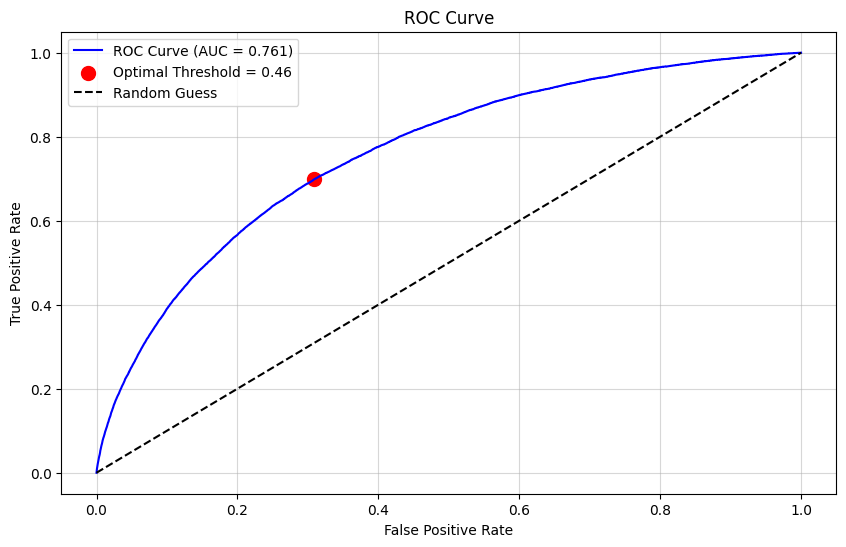


Classification Report:

              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80    226129
         1.0       0.17      0.70      0.27     19876

    accuracy                           0.69    246005
   macro avg       0.56      0.69      0.54    246005
weighted avg       0.90      0.69      0.76    246005



In [35]:
best_model = main()

In [36]:
X_test = test_data.copy()
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

output = pd.DataFrame({"SK_ID_CURR": X_test["SK_ID_CURR"], "TARGET": y_pred_proba})
output.to_csv("submission_final.csv", index=False)

print("Predictions saved to submission_final.csv")

Predictions saved to submission_final.csv
